In [1]:
%matplotlib inline 
import numpy as np
import os
os.chdir('/Users/zhouyu/Google Drive/python4work/NN_Model/')

### Read in matlab .mat data including:
#1. 80 image patches consisted of bar gratings with different bar width and background intensity/mean intensity
#2. MeanResonse measured from the neuron recorded on 01/12, exc mode

In [2]:
import scipy.io
test = scipy.io.loadmat('NN_Train.mat')

In [3]:
test.keys()

['Train_target', '__version__', '__header__', 'Train_img_set', '__globals__']

In [4]:
Train_rawimg = test['Train_img_set']
Train_target = test['Train_target']
print "Training images shape:",Train_rawimg.shape
print "Target exc response shape:", Train_target.shape

Training images shape: (80, 61, 61)
Target exc response shape: (80, 1)


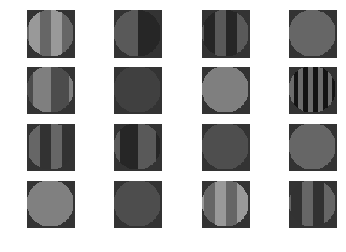

In [5]:
# visualize some samples from the training set:
import matplotlib.pyplot as plt
num_pic = 16
ind = np.random.randint(0,Train_rawimg.shape[0],num_pic)
pos = 0
for i in ind:
    pos+=1
    plt.subplot(4,4,pos)
    plt.imshow((Train_rawimg[i]*255).astype('uint8'),cmap = 'gray',vmin = 0, vmax = 255)
    plt.axis('off')
plt.show()

In [6]:
# First, we do not include a test set
num_train  = 80;
X = np.reshape(Train_rawimg,(Train_rawimg.shape[0],-1))
y = -Train_target.reshape((Train_target.shape[0],))
y = y/max(y) # must normalize!!
# split the data into the trainning set and validation set
from sklearn.model_selection import train_test_split
train_ind, test_ind = train_test_split(range(num_train),test_size = 0.1,random_state = 1)
X_train = X[train_ind,:]
X_test = X[test_ind,:]
y_train = y[train_ind]
y_test = y[test_ind]
print X_train.shape,y_train.shape

(72, 3721) (72,)


### Scikit learn neuronal net (MLP) - Only has L2 regulation

In [7]:
from sklearn.neural_network import MLPRegressor as MLP

In [8]:
## contruct a one-hidden layer neural network
nn = MLP(hidden_layer_sizes = (3,),activation = 'tanh',max_iter = 10000,alpha = 1e-3,
         batch_size = 'auto',
        solver = 'lbfgs',verbose = True,tol = 1e-4,random_state = 2,learning_rate_init = 0.1)


In [9]:
nn.fit(X_train,y_train)
print "Training set score: %f" %nn.score(X_train,y_train)

Training set score: 0.922636


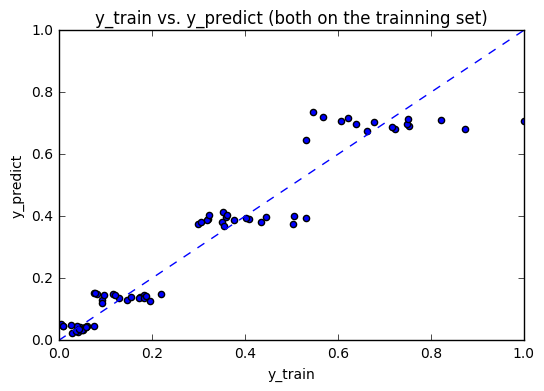

In [10]:
y_predict = nn.predict(X_train)
plt.scatter(y_train,y_predict)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],ls='--')
plt.xlabel('y_train')
plt.ylabel('y_predict')
plt.title('y_train vs. y_predict (both on the trainning set)')

NameError: name 'y_val' is not defined

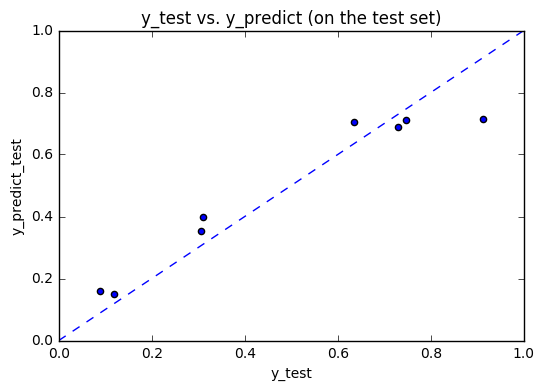

In [11]:
# let's test the model out on the test set
y_predict_test = nn.predict(X_test)
plt.scatter(y_test,y_predict_test)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],ls='--')
plt.xlabel('y_test')
plt.ylabel('y_predict_test')
plt.title('y_test vs. y_predict (on the test set)')
from sklearn.metrics import r2_score
r2 = r2_score(y_val,y_predict_val)
print r2

#### If the neural network gives acceptable answer:
#### Let's examine the weights (representing responses at the subunit level)

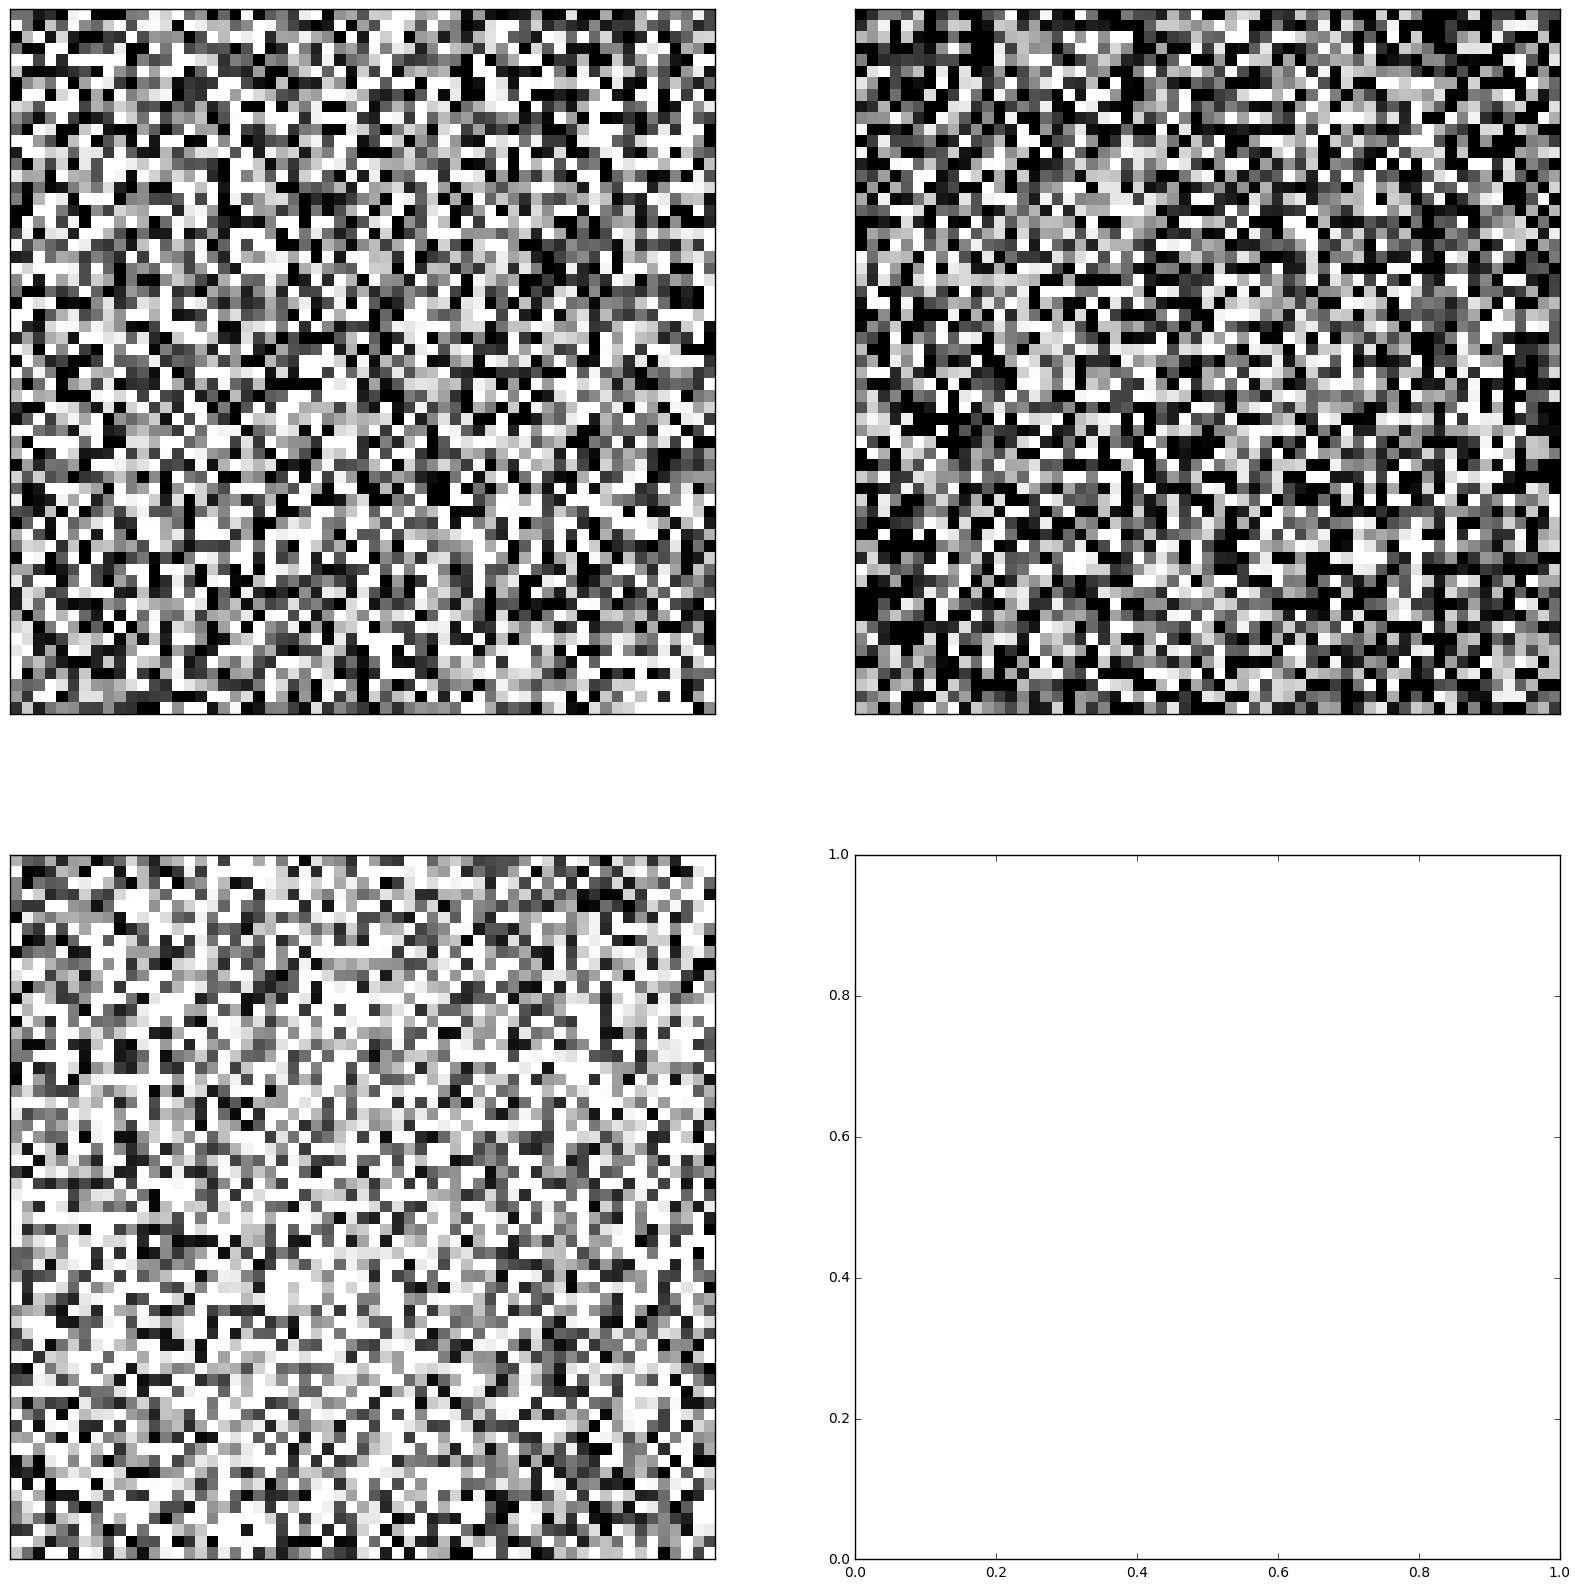

In [57]:
# use global min/max to ensure all weights are shown on the same scale
fig, axes = plt.subplots(2,2,figsize = (20,20))
vmin, vmax = nn.coefs_[0].min(),nn.coefs_[0].max()
for coef,ax in zip(nn.coefs_[0].T,axes.ravel()):
    ax.matshow(coef.reshape(61,61),cmap = plt.cm.gray, vmin = 0.5*vmin, vmax = 0.5*vmax)
    ax.set_aspect('equal')
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [42]:
nn.coefs_[0].shape

(3721, 32)

### keras: Neural net - L1 regulation

In [19]:
#source activate tensorflow
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.regularizers import l1
from keras.optimizers import SGD
from keras.optimizers import Adagrad
model = Sequential()
model.add(Dense(4,input_dim = X_train.shape[1],W_regularizer = l1(0.02),init = 'normal'))
model.add(Activation('tanh'))
#model.add(Dropout(0.1))
model.add(Dense(1,activation = 'linear'))
#sgd = SGD(lr = 0.001, decay = 1e-4,momentum = 0.9)
ada = Adagrad()
model.compile(optimizer = ada,
              loss = 'mse',
              metrics = ['mean_squared_error'])
model.fit(X_train,y_train,nb_epoch = 200,batch_size = 32,verbose = 0,callbacks = None, 
          validation_split = 0.1,shuffle = True)

In [20]:
score = model.evaluate(X_test,y_test)
print score
from sklearn.metrics import r2_score
print r2_score(y_test,model.predict(X_test))
print r2_score(y_train,model.predict(X_train))

8/8 [==============================] - 0s
[0.36728429794311523, 0.10352259129285812]
-0.207867790289
-0.122357223673


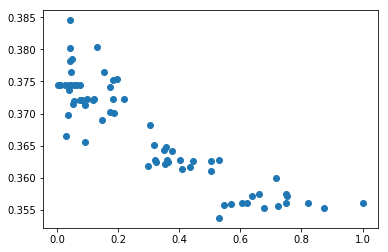

In [21]:
import matplotlib.pyplot as plt
plt.plot(y_train, model.predict(X_train),'o')
#print model.predict(X_train)

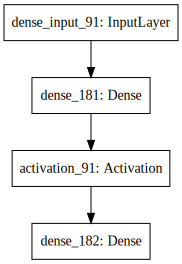

In [413]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog = 'dot',format = 'svg'))

In [22]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print len(weights)

2
0
2


In [23]:
sub_weights = (model.layers[0].get_weights())[0]
print sub_weights.shape

(3721, 4)


-0.0741529 -0.000925314
-0.000174887 0.0351848
-0.000447994 0.000498258
0.000326581 0.0754617


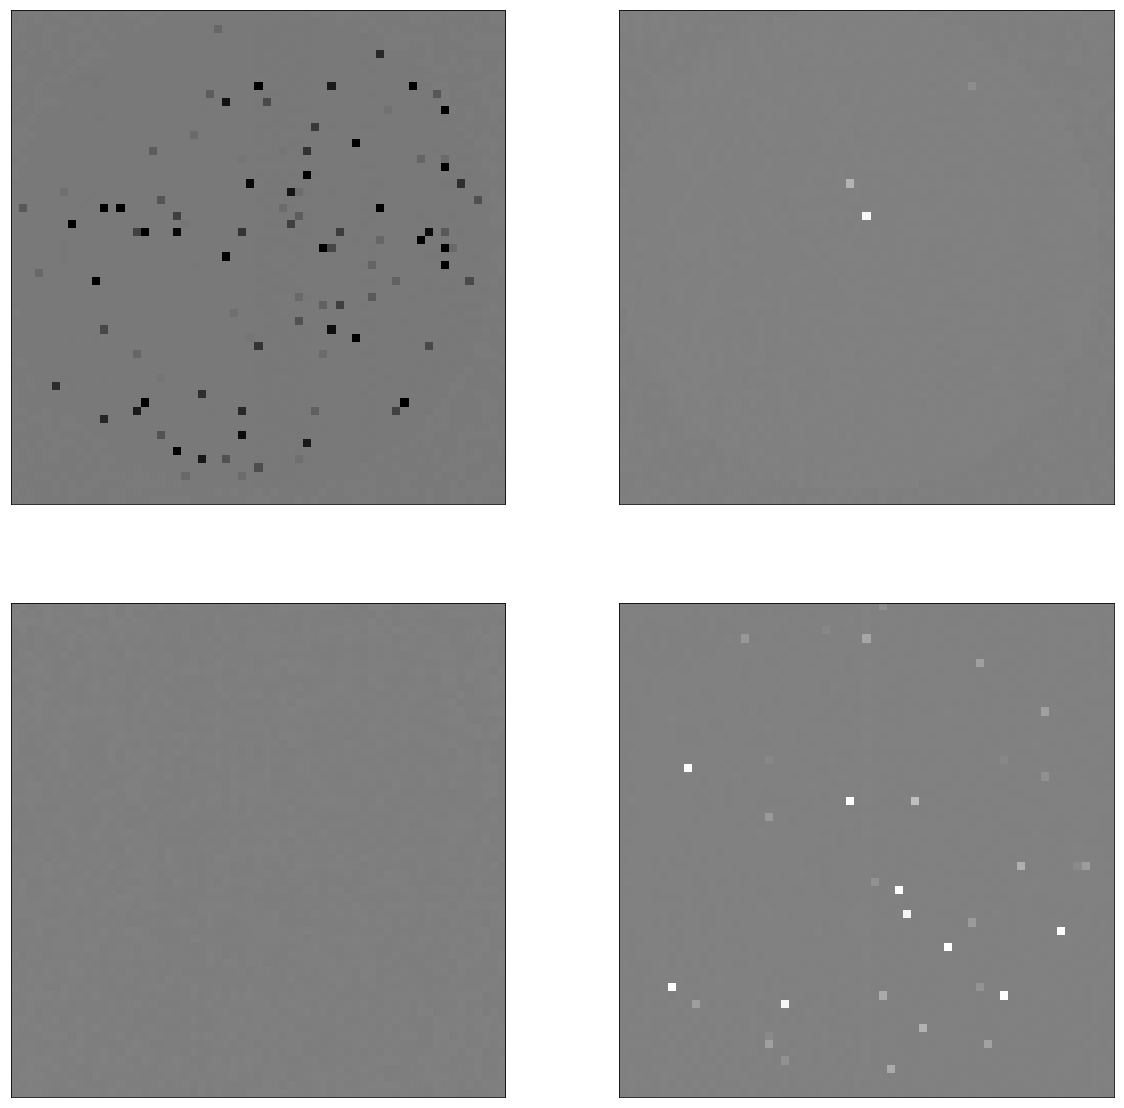

In [24]:
# use global min/max to ensure all weights are shown on the same scale
fig, axes = plt.subplots(2,2,figsize = (20,20))
background = sub_weights.mean()
vmin, vmax = sub_weights.min(),sub_weights.max()
# scale the sub_weights to the region of [0,1]
#sub_weights = (sub_weights - vmin)/(vmax-vmin)
#b1,b2 = sub_weights.min(),sub_weights.max()
for coef,ax in zip(sub_weights.T,axes.ravel()):
    print coef.min(),coef.max()
    ax.matshow(coef.reshape(61,61),cmap = plt.cm.gray, vmin = vmin*0.5, vmax = vmax*0.5)
    ax.set_aspect('equal')
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()


### Cov-Net

In [182]:
sub_weights[29,:]

array([ 0.03207185,  0.02288837,  0.02846457,  0.02603156,  0.02648351,
        0.02751401,  0.01152316,  0.03337727,  0.02608754,  0.02810423,
        0.01231358,  0.02803119,  0.03285656,  0.01844241,  0.01569235,
        0.02644947,  0.0235536 ,  0.0268294 ,  0.02695491,  0.0359711 ,
        0.02859847,  0.0354353 ,  0.02446959,  0.020053  ,  0.02265679,
        0.02450815,  0.02899662,  0.01522901,  0.02885813,  0.14207454,
        0.03759986,  0.02463854], dtype=float32)

In [253]:
print vmin

-0.0297735
